## Open domain question answering system on custom dataset

**Основные задачи:**  
1. Построить открытую вопросно-ответную систему на пользовательских данных.  
2. Оценить результаты работы: сравнить с результатами закрытой вопросно-ответной системы и результатами датасета SberQuAD.  
   
В качестве метрик будут использованы F1, EM, а также доля вопросов, для которых моделью `Reader` был выбран правильный контекст.  
В качестве датасета будет использована часть параграфов [отчёта](https://e-disclosure.ru/portal/files.aspx?id=9480&type=2&attempt=1) о деятельности ПАО Т Плюс за 2019 год.  
Результаты датасета SberQuAD [здесь](https://github.com/nata-vorobyeva/QA-nlp/blob/master/ODQA.ipynb).

**План аналогичен работе с датасетом SberQuAD:**  
1. Оценить метрики качества закрытой вопросно-ответной системы, когда модели предлагается найти ответ в единственном "родном" для неё контексте. Будем использовать эти метрики в качестве эталонных, чтобы оценить, насколько они снижаются при переходе в открытый тип, когда у модели вместо одного заданного контекста есть некоторое их множество.   
Модель для поиска ответа в контексте (`Reader`) построена нами [ранее](https://github.com/nata-vorobyeva/QA-nlp/blob/master/ReaderTrain.ipynb). Будем использовать сохранённые веса этой модели.  
2. Построить модель `Retriever`, выбирающую из всего множества контекстов `n` наиболее подходящих. В качестве меры похожести используется косинусная мера близости векторов. Для преобразования вопросов и контекстов в вектора для определения похожести используется tf-idf подход. Основа модели - [разработка](http://docs.deeppavlov.ai/en/0.17.2/apiref/models/vectorizers.html) команды DeepPavlov, позволяющая создавать tf-idf вектора для контекстов и вопросов.  
Наша задача здесь - дополнить её возможностью выбирать наиболее подходящие констексты в смысле выбранного критерия оптимальности.   
3. Найти итоговый ответ для каждого вопроса с помощью модели `Reader`. Для этого:  
- для каждого из выбранных контекстов предсказать начало и конец ответа;  
- выбрать наиболее правдоподобный контекст. Критерий - наибольшая совместная вероятность того, что выбранные начало и конец ответа являются верными. При необходимости скорректировать критерий дополнительными весами;
- сформировать итоговый текстовый ответ.  
4. Оценить критерии качества совместной работы `Retriever` и `Reader`. Оценить снижение метрик в сравнении с результатами п.1. Дополнительно сравнить с результатами датасета SberQuAD.

### 0. Нормализация текста

Идея 1: деление текста на контексты (документы). Проверка показала, что лучшим вариантов в смысле выбранных метрик является деление по абзацам: один абзац - один контекст. В этом есть смысл, т.к. зачастую деление на абзацы при написании текста человеком уже содержит его экспертные знания о смысле 

Идея 2: помочь Retriever модели. Напомним, что она построена на tf-idf подходе, который не распознаёт синонимы, не отличает аббревиатуры от расшифровки итд. Перечисленные действия выполнены вручную, но их можно автоматизировать.  
Что сделано.
1. Синонимы `Общество`, `Компания`, `ПАО Т Плюс`, `ПАО` заменены на единое понятие `Т Плюс`.  
2. Все аббревиатуры расшифрованы.  
3. Указания на годы (текущий, прошлый, следующий итд) заменены на числовые значения: 2019, 2018, 2020 итд.  

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5, 6"
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from deeppavlov.models.tokenizers.ru_tokenizer import RussianTokenizer
from itertools import repeat
from scipy.special import softmax
from transformers import logging, AutoTokenizer, AutoModel
logging.set_verbosity_error()

import util
from models import Retriever, RUBertForQA

### 1. Оценка качества закрытой вопросно-ответной системы

Веса для модели `Reader` уже подготовлены. Загрузим их.

In [3]:
BATCH_SIZE = 2**8
DROPOUT = 0.5
model_name = "DeepPavlov/rubert-base-cased"
max_length = 512
tokenizer = AutoTokenizer.from_pretrained(model_name)
path_to_dict = '../model checkpoints/QA_best.pt'
bert = AutoModel.from_pretrained(model_name, num_hidden_layers = 9)
reader = RUBertForQA(bert, DROPOUT)
reader = torch.nn.DataParallel(reader, device_ids=[0, 1]).cuda()
reader.load_state_dict(torch.load(path_to_dict))

/home/naanvorobeva/miniconda3/envs/python3.7/lib/python3.7/site-packages/cryptography/hazmat/backends/openssl/x509.py:17: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,


<All keys matched successfully>

Читаем файл с выборкой, готовим словари с контекстами (далее - документами), вопросами и ответами. `question_context` - словарь, содержащий для каждого id вопроса id "родного" документа.

In [4]:
context = util.read_context_lb('data/contexts_lb.json')
question, answer, question_context = util.read_question_lb('data/questions_lb.json')
query_id = list(question.keys())
query_text = list(question.values())
native_doc_id = list(question_context.values())
native_doc_text = [context[v] for v in native_doc_id]
print('Number of questions:', len(question))
print('Number of documents:', len(context))

Number of questions: 120
Number of documents: 132


 Получим метрики.

In [6]:
# get encodings and create data loader object
encoding_init = (tokenizer(native_doc_text, query_text,
                             truncation=True, padding=True, max_length = 512, return_tensors = 'pt'))
dataset_init = util.SquadDataset(encoding_init)
loader_init = DataLoader(dataset_init, batch_size=BATCH_SIZE, shuffle=False)

# get predictions (logits), construct text predicted answers and evaluate quality
logp_start_init, logp_end_init, _ = util.get_logits(reader, loader_init, get_loss=False)
pred_answer_init, _ = util.get_answer(logp_start_init, logp_end_init, 
    native_doc_text, native_doc_id, query_id, encoding_init)
metrics_init = util.eval_dicts(answer, pred_answer_init, False)
print(metrics_init)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]

{'F1': 83.89834708684822, 'EM': 69.16666666666667}


Посмотрим, есть ли токены, которые не смог преобразовать tokenizer

In [7]:
unk_token = tokenizer.unk_token
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)
num_unk_seq = torch.unique(torch.where(encoding_init['input_ids'] == unk_token_idx)[0])
print('Number of examples with UNK token in a dataset:', num_unk_seq.shape[0])

Number of examples with UNK token in a dataset: 0


Запомним: F1 = 84%, EM = 69%. Результаты даже лучше SberQuAD: 82/63. И в преобразованных данных нет UNK токенов. Начало хорошее.

### 2. Модель `Retriever`

Подготовим данные

In [8]:
doc = list(context.values())
doc_id = list(context.keys())
doc_num = list(range(len(doc)))
save_path = 'tf_idf_lb2.npz'
load_path = 'tf_idf_lb2.npz'
hash_size = 2**24
tokenizer_tf_idf = RussianTokenizer(lemmas = True, ngram_range = (1, 2))

Следующая ячейка нужна для единовременной загрузки в модель документов, формирования из них tf-idf матрицы и сохранения её локально по пути в переменной `save_path`. Если матрица уже создана, выполнение ячейки можно пропустить.

In [8]:
retriever_init = Retriever(tokenizer = tokenizer_tf_idf, hash_size = hash_size, save_path = save_path, 
                                load_path = load_path, **{"mode": 'train'})
retriever_init.fit(docs = doc, doc_ids = doc_id, doc_nums = doc_num)
retriever_init.save()

2022-05-29 09:01:41.933 INFO in 'deeppavlov.models.vectorizers.hashing_tfidf_vectorizer'['hashing_tfidf_vectorizer'] at line 153: Tokenizing batch...
2022-05-29 09:01:43.479 INFO in 'deeppavlov.models.vectorizers.hashing_tfidf_vectorizer'['hashing_tfidf_vectorizer'] at line 155: Counting hash...
2022-05-29 09:01:43.489 INFO in 'deeppavlov.models.vectorizers.hashing_tfidf_vectorizer'['hashing_tfidf_vectorizer'] at line 214: Saving tfidf matrix to /home/naanvorobeva/lab/QA/tf_idf_lb2.npz


Создадим объект модели, загрузим в неё вопросы и получим id наиболее релевантных документов - `retrieved_doc_id`.  

In [9]:
retriever = Retriever(tokenizer = tokenizer_tf_idf, hash_size = hash_size, 
                                       save_path = save_path, load_path = load_path, **{"mode": 'infer'})
n = 3
retrieved_doc_id, total_doc_similarity = retriever.retrieve(query_text, n)
retrieved_doc_similarity = np.partition(total_doc_similarity, -n, axis=0)[-n:].T
retrieved_doc_text = [context[k] for k in retrieved_doc_id]

2022-06-26 12:39:46.565 INFO in 'deeppavlov.models.vectorizers.hashing_tfidf_vectorizer'['hashing_tfidf_vectorizer'] at line 264: Loading tfidf matrix from /home/naanvorobeva/lab/QA/tf_idf_lb2.npz
2022-06-26 12:39:47.382 INFO in 'deeppavlov.models.vectorizers.hashing_tfidf_vectorizer'['hashing_tfidf_vectorizer'] at line 264: Loading tfidf matrix from /home/naanvorobeva/lab/QA/tf_idf_lb2.npz


Оценим точность модели (показатель `accuracy`): для каждого вопроса проверим, входит ли "родной" для него документ в список документов, выбранных моделью. Число вопросов с правильно выбранным документом делим на общее число вопросов.  
Построим зависимость показателя `accuracy` от количества выбранных документов для каждого вопроса.

Text(0.5, 1.0, 'Retriever accuracy for custom data')

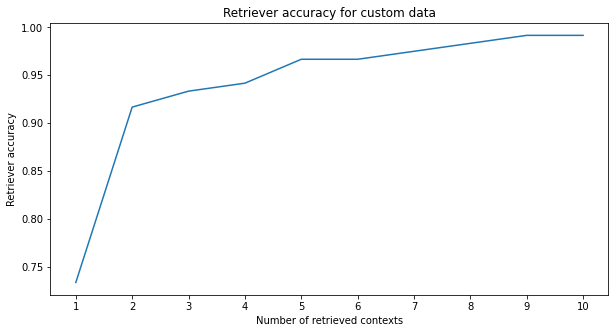

In [16]:
retriever_acc = []
num_retrieved_doc = 10
for i in range(1, num_retrieved_doc + 1):
    retriever_acc.append(
        util.retriever_accuracy(total_doc_similarity, query_id, doc_id, question_context, i))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

ax.plot(range(1, num_retrieved_doc + 1), retriever_acc)
ax.set_xlabel('Number of retrieved contexts')
ax.set_xticks(range(1, num_retrieved_doc + 1))
ax.set_ylabel('Retriever accuracy')
ax.set_title('Retriever accuracy for custom data')

Результаты для `n = 3` документов: в 93% случаев модель в список релевантных документов включает "родной" для вопроса документ. Для SberQUAD показатель был аналогичным: 94%. Остановимся пока на `n = 3`.

### Предсказание ответов. Модель `Reader`

Наконец, загрузим в модель `Reader` вопросы и выбранные релевантные документы. Для каждого вопроса выберем наиболее правдоподобный ответ в смысле выбранного критерия: максимальная совместная вероятность того, что предсказанные начало и конец ответа являются верными.  
Аналогично посмотрим на точность модели `Reader`: как часто модель извлекает итоговый ответ из "родного" для вопроса документа.

In [11]:
# expand queries to satisfy dimension.
# Query list has lenght [number of queries],
# but doc list lenght is [number of queries * n], n is number of docs retrieved for each query.
# so we need to duplicate each query n times
retrieved_query_text = [x for item in query_text for x in repeat(item, n)]

# get encodings and create data loader object
encoding = (tokenizer(retrieved_doc_text, retrieved_query_text,
                             truncation=True, padding=True, max_length = max_length, return_tensors = 'pt'))
dataset = util.SquadDataset(encoding)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# get predictions (logits), construct text predicted answers and evaluate quality
logp_start, logp_end, _ = util.get_logits(reader, loader, get_loss=False)
pred_answer, pred_doc_id = util.get_answer(logp_start, logp_end, 
    retrieved_doc_text, retrieved_doc_id, query_id, encoding)
metrics = util.eval_dicts(answer, pred_answer, False)
print(metrics)
acc = np.sum(pred_doc_id==native_doc_id) / len(native_doc_id)
print('Reader accuracy:', acc)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.23it/s]

{'F1': 51.95238095238095, 'EM': 45.833333333333336}
Reader accuracy: 0.5


Результаты плачевные:  
    1. Метрики качества существенно снизились: F1/EM = 52/46 против 84/69 для закрытой вопросно-ответной системы.  
    2. Модель выбирает верный документ только в 50% случаев. То есть если в список релевантных документов, выбранных `Retriever`, попал правильный документ, модель `Reader` может извлечь ответ из другого документа.    
  
  
Как и для SberQuAD, добавим в `Reader` в критерий выбора документа для поиска ответа дополнительные веса, пропорциональные мере схожести документа и вопроса. Нормируем меру схожести в веса с помощью `softmax`, добавив "температуру".

Заново получим ответы для тех же данных, но с учётом весов.

In [13]:
T = 0.01
weights = softmax(retrieved_doc_similarity / T, axis=1)

# here we don't need to create encodings, data loader and get logits.
# we can use existing predictions. 
# All we need to do is to add weights to get_answer function

# construct text predicted answers and evaluate quality
pred_answer_weighted, pred_doc_id_weighted = util.get_answer(logp_start, logp_end, 
    retrieved_doc_text, retrieved_doc_id, query_id, encoding, weights)
metrics_weighted = util.eval_dicts(answer, pred_answer_weighted, False)
print(metrics_weighted)
acc_weighted = np.sum(pred_doc_id_weighted==native_doc_id) / len(native_doc_id)
print('Reader accuracy with weights:', acc_weighted)

{'F1': 68.68993107314105, 'EM': 58.333333333333336}
Reader accuracy with weights: 0.775


Стало лучше, но недостаточно хорошо. Напомним, что аналогичные метрики для SberQuAD составили 75/58 при 89% показателе `Reader accuracy` (доля правильно выбранных документов для вопроса). У нас только 69/58 при 78%. 

### 4. Оценка результатов. Выводы

Соберём метрики качества. Будем сравнивать результаты на пользовательском датасете для систем закрытого типа и открытого типа с весами. Промежуточный вариант без весов не представляет особого интереса. Приведем также аналогичные результаты для датасета SberQuAD

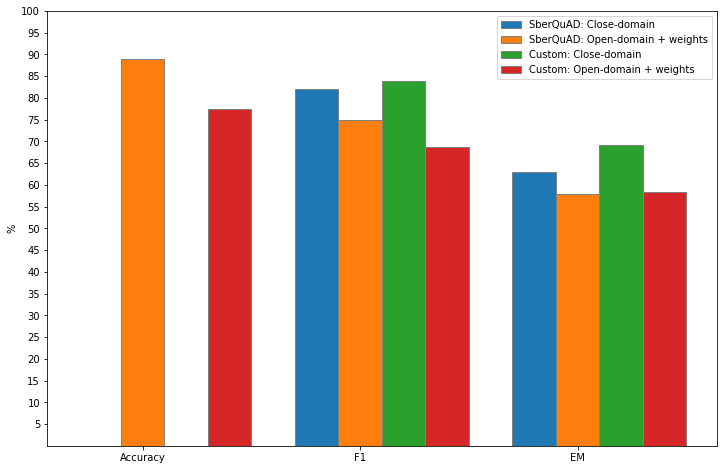

In [14]:
# set width of bar
barWidth = 0.2
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
sberquad_close = [0, 82, 63]
sber_open = [89, 75, 58]
custom_close = [0, metrics_init['F1'], metrics_init['EM']]
custom_open = [acc_weighted * 100, metrics_weighted['F1'], metrics_weighted['EM']]

# Set position of bar on X axis
br1 = np.arange(len(sber_open))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

# Make the plot
plt.bar(br1, sberquad_close, width = barWidth, edgecolor ='grey', label ='SberQuAD: Close-domain')
plt.bar(br2, sber_open, width = barWidth, edgecolor ='grey', label ='SberQuAD: Open-domain + weights')
plt.bar(br3, custom_close, width = barWidth, edgecolor ='grey', label ='Custom: Close-domain')
plt.bar(br4, custom_open, width = barWidth, edgecolor ='grey', label ='Custom: Open-domain + weights')

# Adding ticks
plt.ylabel('%')
plt.yticks([i for i in range(5, 105, 5)])
plt.xticks([r + barWidth for r in range(len(sber_open))],
        ['Accuracy', 'F1', 'EM'])
 
plt.legend()
plt.show()

По понятным причинам лучшие метрики качества показала закрытая модель: F1/EM = 81/65.  
Лучшие результаты для открытой модели: F1/EM = 65/53. Причина падения: очень невысокая способность `Reader` правильно оценить верояность, что верный ответ находится в "родном" для вопроса документе. Так, ответ выбран из верного документа только в 77% случаев, это очень мало. Аналогичный результат для  SberQUAD: 89%.  
Возможные причины:  
1. Особенность пользовательского датасета: многие параграфы отчёта, который использовался для формирования датасета, рассказывают об одних и тех же показателях деятельности компании, только в разных временных и других аспектах. То есть параграфы используют схожую лексику, из-за чего выбор ответа становится не так прост, как для SberQuAD.   
  
В ноутбуке результаты не представлены, но мы пробовали изменить количество документов, выбираемых `Retriever` для каждого вопроса. Это не привело в значимым результатам.
   

### Дополнительно

В [файле](https://github.com/nata-vorobyeva/QA-nlp/blob/master/ODQA_LB_results.txt) собрали текстовые результаты открытой вопросно-ответной системы: вопрос, документ, предсказанный и правильный ответы